# Epistatic Interactions
based on the code from [Phillips et al.](https://elifesciences.org/articles/71393#s4)

In [1]:
!pwd

/projects/brpe7306/fab-library-barcoding


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from remove_silent import convert_to_one_hot, remove_silent

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "figure.figsize": (7, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)


def extract_mutations_from_str(input_str):
    mut_list = input_str.split("|")
    mut_list = [mut.split(":")[1] for mut in mut_list]
    mut_list = [mut.split(";") for mut in mut_list]
    mut_list = mut_list[0] + mut_list[1]
    mut_list = [mut.split("-")[0] for mut in mut_list]
    mut_list = [mut for mut in mut_list if mut != "WT"]
    return mut_list

## Read in data

In [42]:
data = pd.read_csv("4A8_CC121_combined_mle.csv")
data = data[data["Variant"].str.startswith("4A8")]
data["Variant"] = data["Variant"].apply(remove_silent)
data = data[data["n"] == 9]
print(len(data))
# Desired mutations: M59I, Q120K, S7T, T94M, V109L, and D110E
# Undesired mutations:
undesired_mutations = [
    "D52N-AAT",
    "Q105G-GGA",
    "Q120R-CGT",
    "S128P-CCA",
    "S88Y-TAT",
    "T122I-ATC",
    "T123L-CTG",
    "T76I-ATA",
    "W118C-TGC",
]
for mut in undesired_mutations:
    data = data[~data["Variant"].str.contains(mut)]
one_hots, mlb = convert_to_one_hot(data.loc[:, ("Variant")], keep_mlb=True)
data = data.join(
    pd.DataFrame.sparse.from_spmatrix(one_hots, index=data.index, columns=mlb.classes_)
)
mutations = mlb.classes_.tolist()[1:]
data.drop(columns=[""], inplace=True)
data["num_muts"] = data[mutations].sum(axis=1)
print(data[mutations + ["num_muts"]])

352
     D110E-GAG  M59I-ATC  Q120K-AAA  S7T-ACT  T94M-ATG  V109L-CTG  num_muts
1            0         0          0        1         0          1         2
2            0         0          0        0         1          0         1
4            0         1          0        1         0          0         2
5            0         0          1        1         1          0         3
6            1         1          0        1         0          0         3
..         ...       ...        ...      ...       ...        ...       ...
492          0         1          1        1         1          0         4
494          0         0          1        0         1          0         2
495          0         0          1        0         0          0         1
496          0         0          0        1         0          0         1
497          0         0          1        1         0          0         2

[346 rows x 7 columns]


# Making Arrays for Regression

In [43]:
affinities = data[["Fmax"]].values.flatten().astype(np.float64)
print(affinities.shape)
print(mutations)
# genotypes = np.array(data[[x for x in mutations]].copy(), dtype=int)
genotypes = data["num_muts"]
print(genotypes.shape)

(346,)
['D110E-GAG', 'M59I-ATC', 'Q120K-AAA', 'S7T-ACT', 'T94M-ATG', 'V109L-CTG']
(346,)


## CV to choose optimal order of interaction

In [54]:
num_folds = 10
max_order = 6

# set up permutation
np.random.seed(7802)
indices_permuted = np.random.permutation(np.arange(len(genotypes)))
size_test = int(1.0 / float(num_folds) * len(genotypes))
size_train = len(genotypes) - size_test
print(size_test, size_train)

# lists to store r squared values
rsq_train_list = np.zeros((max_order + 1, num_folds))
rsq_test_list = np.zeros((max_order + 1, num_folds))

# loop over CV folds
for f in range(num_folds):
    # get train & test sets
    start = int(f * size_test)
    stop = int((f + 1) * size_test)
    genos_train = np.concatenate((genotypes[:start], genotypes[stop:])).reshape(-1, 1)
    genos_test = np.array(genotypes[start:stop]).reshape(-1, 1)
    affinities_train = np.concatenate((affinities[:start], affinities[stop:]))
    affinities_test = affinities[start:stop]

    print("Fold: ", f)

    # initialize zero-order (intercept-only) model
    genos_train_previous = np.full(len(genos_train), 1.0)
    genos_test_previous = np.full(len(genos_test), 1.0)

    reg_previous = sm.OLS(affinities_train, genos_train_previous).fit()
    reg_coefs_previous = reg_previous.params

    rsquared_train_previous = reg_previous.rsquared
    rsquared_test_previous = 1 - np.sum(
        (affinities_test - reg_previous.predict(genos_test_previous)) ** 2
    ) / np.sum((affinities_test - np.mean(affinities_test)) ** 2)
    rsq_train_list[0, f] = rsquared_train_previous
    rsq_test_list[0, f] = rsquared_test_previous

    # mean_pheno_train = np.mean(affinities_train)
    # mean_pheno_test = np.mean(affinities_test)

    # fit models of increasing order
    for order in range(1, max_order + 1):
        # print('Order: ',str(order))
        poly_current = PolynomialFeatures(order, interaction_only=True)
        genos_train_current = poly_current.fit_transform(genos_train)
        genos_test_current = poly_current.fit_transform(genos_test)

        reg_current = sm.OLS(affinities_train, genos_train_current).fit()
        reg_coefs_current = reg_current.params
        # print(reg_coefs_current) # FIXME
        reg_CIs_current = reg_current.conf_int(alpha=0.05, cols=None)
        reg_stderr = reg_current.bse
        # NOTE: Use mse_resid for BIC if you choose to use that

        rsquared_train_current = reg_current.rsquared
        rsquared_test_current = 1 - np.sum(
            (affinities_test - reg_current.predict(genos_test_current)) ** 2
        ) / np.sum((affinities_test - np.mean(affinities_test)) ** 2)
        rsq_train_list[order, f] = rsquared_train_current
        rsq_test_list[order, f] = rsquared_test_current

# average over folds
mean_rsq_train = np.mean(rsq_train_list, axis=1)
stdev_rsq_train = np.std(rsq_train_list, axis=1)
mean_rsq_test = np.mean(rsq_test_list, axis=1)
stdev_rsq_test = np.std(rsq_test_list, axis=1)

optimal_order = np.argmax(mean_rsq_test)
print("Optimal order: ", optimal_order)

34 312
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
Optimal order:  1


In [55]:
# print CV results to file
with open("./Output/CV_rsquared.csv", "w") as writefile:
    rsq_writer = csv.writer(writefile)
    rsq_writer.writerow(["Type", "Order", "Mean", "Std"])
    for i in range(len(mean_rsq_train)):
        rsq_writer.writerow(["Train", str(i), mean_rsq_train[i], stdev_rsq_train[i]])
    for i in range(len(mean_rsq_test)):
        rsq_writer.writerow(["Test", str(i), mean_rsq_test[i], stdev_rsq_test[i]])
    writefile.close()

## Fit final models

Order:  1
[[2]
 [1]
 [2]
 [3]
 [3]
 [2]
 [3]
 [3]
 [0]
 [0]]
[28699.63 19847.27 31532.36 39845.13 44286.67 14440.92 14017.37 29846.92
 25524.66 16812.12]
[[1. 2.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 3.]
 [1. 2.]
 [1. 3.]
 [1. 3.]
 [1. 0.]
 [1. 0.]]
Params:  2
Performance:  0.16134883311918058


ORDER: 1


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     66.18
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           7.57e-15
Time:                        12:34:05   Log-Likelihood:                -3239.9
No. Observations:                 346   AIC:                             6484.
Df Residuals:                     344   BIC:                             6492.
Df Model:                           1                            

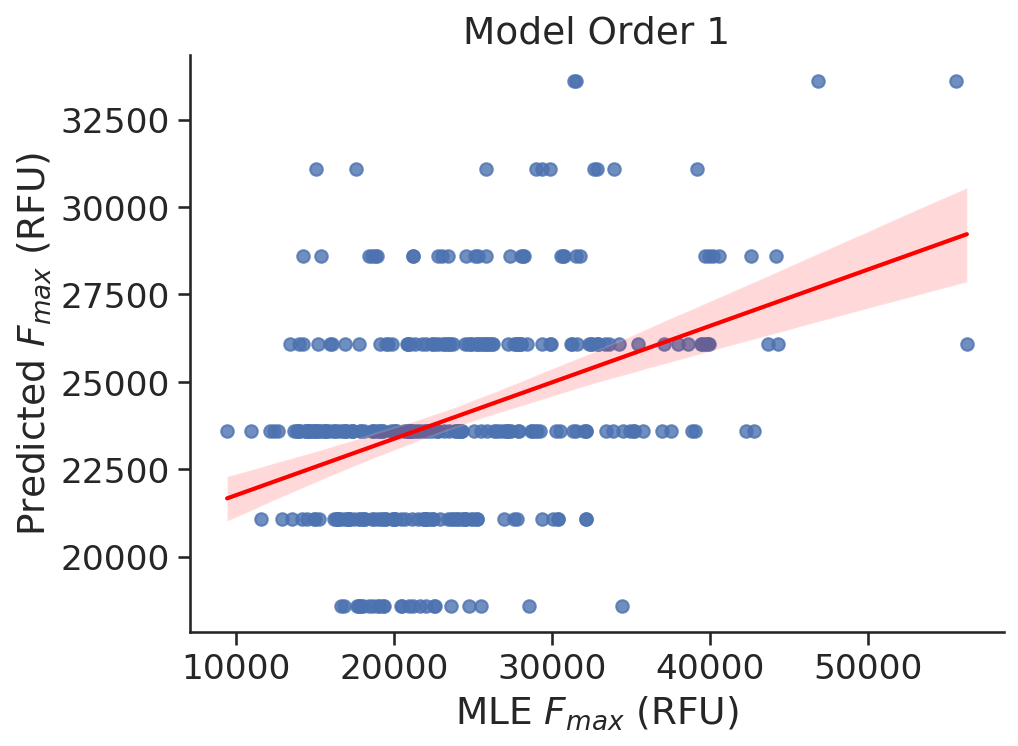

<Figure size 1050x750 with 0 Axes>

In [70]:
# fit models of increasing order
from patsy import dmatrices

genotypes_permuted = np.array(genotypes).reshape(-1, 1)
affinities_permuted = affinities
print("Order: ", str(order))
poly_current = PolynomialFeatures(order, interaction_only=True)
genotypes_current = poly_current.fit_transform(genotypes_permuted)
print(genotypes_permuted[:10])
print(affinities_permuted[:10])
print(genotypes_current[:10])
# fit
reg_current = sm.OLS(affinities_permuted, genotypes_current).fit()
reg_coefs_current = reg_current.params
reg_CIs_current = reg_current.conf_int(
    alpha=0.05 / float(len(reg_coefs_current)), cols=None
)
reg_stderr = reg_current.bse
reg_pvalues = reg_current.pvalues

num_sig = len(np.where(reg_pvalues < 0.05 / float(len(reg_coefs_current)))[0])

predicted_phenos_permuted = reg_current.predict(genotypes_current)
rsquared_current = reg_current.rsquared
print("Params: ", len(reg_coefs_current))
print("Performance: ", rsquared_current)


coef_names = poly_current.get_feature_names_out(input_features=["num_muts"])
with open("./Output/" + str(order) + "order.csv", "w") as writefile:
    coef_writer = csv.writer(writefile, delimiter=",")
    # coef_writer.writerow(['Params: ', len(reg_coefs_current)])
    # coef_writer.writerow(['Performance: ', rsquared_current])
    coef_writer.writerow(
        [
            "Term",
            "Coefficient",
            "Standard Error",
            "p-value",
            "95% CI lower",
            "95% CI upper",
        ]
    )
    coef_writer.writerow(["Intercept", reg_coefs_current[0]])
    for i in range(1, len(reg_coefs_current)):
        coef_writer.writerow(
            [
                ",".join(coef_names[i].split(" ")),
                reg_coefs_current[i],
                reg_stderr[i],
                reg_pvalues[i],
                reg_CIs_current[i][0],
                reg_CIs_current[i][1],
            ]
        )
    writefile.close()

df = pd.DataFrame(
    {"Predicted": predicted_phenos_permuted, "Actual": affinities_permuted}
)

y, X = dmatrices("Predicted ~ Actual", data=df, return_type="dataframe")

model = sm.OLS(y, X)
results = model.fit()
print(f"\n\nORDER: {order}\n\n")
print(results.summary())
plot = sns.regplot(
    x="Actual", y="Predicted", data=df, line_kws={"lw": 2, "color": "red"}
)
plt.title(f"Model Order {order}")
plt.xlabel(r"MLE $F_{max}$ (RFU)")
plt.ylabel(r"Predicted $F_{max}$ (RFU)")
plt.show()
# plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
plt.clf()